In [1]:
# https://www.kaggle.com/code/ozlemilgun/market-basket-analysis-with-apriori-algorithm
# https://www.facebook.com/tautologyai/videos/303900072700235
# https://www.kaggle.com/code/ekrembayar/apriori-association-rules-grocery-store
# https://www.youtube.com/watch?v=RDQplhHYUr0

In [2]:
import warnings
warnings.simplefilter("ignore")

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import re

In [5]:
from itertools import combinations

In [6]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# 1. Load data

In [7]:
df = pd.read_excel("online_retail_II.xlsx", sheet_name='Year 2009-2010')

In [8]:
df.shape

(525461, 8)

# 2. Check data quality

In [9]:
# data type

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [11]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [12]:
# columns name

In [13]:
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')

In [14]:
# select only useful columns

In [15]:
df = df[['Invoice','StockCode','Description','InvoiceDate']]

In [16]:
# data type

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   InvoiceDate  525461 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 16.0+ MB


In [18]:
# check missing value

In [19]:
df.isna().sum()

Invoice           0
StockCode         0
Description    2928
InvoiceDate       0
dtype: int64

In [20]:
df = df.dropna()

In [21]:
# check white space

In [22]:
def empty_or_whitespace_strings(df):
    string_columns = df.select_dtypes(include=['object']).columns
    empty_whitespace_check = df[string_columns].applymap(lambda x: isinstance(x, str) and x.isspace())

    count_empty_whitespace = empty_whitespace_check.sum()
    rows_with_whitespace_indices = empty_whitespace_check.any(axis=1)
    list_row_with_whilespace_indices = df.index[rows_with_whitespace_indices].tolist()

    return count_empty_whitespace, list_row_with_whilespace_indices

In [23]:
show_whilespace, indices_whilesapce = empty_or_whitespace_strings(df)

In [24]:
show_whilespace

Invoice        0
StockCode      0
Description    0
dtype: int64

In [25]:
# check unique value

In [26]:
for i in df.columns:
    print('Columns name: ', i)
    print('Unique value: ', df[i].unique())
    print('Count unique value: ', df[i].nunique())
    print('-'*10)

Columns name:  Invoice
Unique value:  [489434 489435 489436 ... 538169 538170 538171]
Count unique value:  25888
----------
Columns name:  StockCode
Unique value:  [85048 '79323P' '79323W' ... 22935 22933 21120]
Count unique value:  4276
----------
Columns name:  Description
Unique value:  ['15CM CHRISTMAS GLASS BALL 20 LIGHTS' 'PINK CHERRY LIGHTS'
 ' WHITE CHERRY LIGHTS' ... '*Boombox Ipod Classic' 'faulty'
 'Dotcom sales']
Count unique value:  4681
----------
Columns name:  InvoiceDate
Unique value:  <DatetimeArray>
['2009-12-01 07:45:00', '2009-12-01 07:46:00', '2009-12-01 09:06:00',
 '2009-12-01 09:08:00', '2009-12-01 09:24:00', '2009-12-01 09:28:00',
 '2009-12-01 09:43:00', '2009-12-01 09:44:00', '2009-12-01 09:46:00',
 '2009-12-01 09:50:00',
 ...
 '2010-12-09 17:25:00', '2010-12-09 17:27:00', '2010-12-09 17:32:00',
 '2010-12-09 17:34:00', '2010-12-09 18:09:00', '2010-12-09 18:58:00',
 '2010-12-09 19:23:00', '2010-12-09 19:28:00', '2010-12-09 19:32:00',
 '2010-12-09 20:01:00']
Len

In [27]:
# check Description

In [28]:
description_counts = df.groupby('StockCode').agg(number_description=('Description', pd.Series.nunique)).reset_index()

In [29]:
multiple_descriptions = description_counts[description_counts['number_description'] > 1]

In [30]:
multiple_descriptions = multiple_descriptions.sort_values("number_description", ascending=False)

In [31]:
multiple_descriptions

,StockCode,number_description
1522,22423,6
1817,22734,5
1454,22345,4
3805,85099B,4
1489,22384,4
...,...,...
1475,22366,2
1476,22367,2
1486,22381,2
1487,22382,2


In [32]:
df[df['StockCode'] == 'DCGSSGIRL']

,Invoice,StockCode,Description,InvoiceDate
241372,512738,DCGSSGIRL,update,2010-06-17 14:11:00
244831,513099,DCGSSGIRL,GIRLS PARTY BAG,2010-06-21 15:13:00
246184,513200,DCGSSGIRL,GIRLS PARTY BAG,2010-06-22 16:28:00
249938,513574,DCGSSGIRL,GIRLS PARTY BAG,2010-06-25 15:13:00
251930,513655,DCGSSGIRL,GIRLS PARTY BAG,2010-06-28 10:02:00
253997,513907,DCGSSGIRL,GIRLS PARTY BAG,2010-06-29 12:08:00
385192,526405,DCGSSGIRL,GIRLS PARTY BAG,2010-10-11 13:53:00
425616,530060,DCGSSGIRL,GIRLS PARTY BAG,2010-11-01 11:35:00
427107,530140,DCGSSGIRL,GIRLS PARTY BAG,2010-11-01 16:45:00
465555,533338,DCGSSGIRL,GIRLS PARTY BAG,2010-11-16 18:18:00


In [33]:
df = df[~df['StockCode'].isin(multiple_descriptions['StockCode'])]

In [34]:
# check StockCode

In [35]:
stockcode_counts = df.groupby('Description').agg(number_stockcode=('StockCode', pd.Series.nunique)).reset_index()

In [36]:
multiple_stockcode = stockcode_counts[stockcode_counts['number_stockcode'] > 1]

In [37]:
multiple_stockcode = multiple_stockcode.sort_values("number_stockcode", ascending=False)

In [38]:
multiple_stockcode

,Description,number_stockcode
1844,"METAL SIGN,CUPCAKE SINGLE HOOK",6
3450,damages,3
803,COLOURING PENCILS BROWN TUBE,3
2709,SET OF 3 PINK FLYING DUCKS,2
2630,S/4 IVORY MINI ROSE CANDLE IN BOWL,2
...,...,...
1073,ENGLISH ROSE NOTEBOOK A7 SIZE,2
1068,ENGLISH ROSE HOT WATER BOTTLE,2
1057,ENAMEL PINK TEA CONTAINER,2
1026,EDWARDIAN PARASOL PINK,2


In [39]:
df[df['Description'] == 'damages']

,Invoice,StockCode,Description,InvoiceDate
3168,489663,35605A,damages,2009-12-01 18:02:00
73227,496006,84641,damages,2010-01-28 12:30:00
91575,498034,35978,damages,2010-02-16 10:08:00
265660,515069,35978,damages,2010-07-08 10:57:00


In [40]:
df = df[~df['Description'].isin(multiple_stockcode['Description'])]

In [41]:
# check unique value (again)

In [42]:
for i in df.columns:
    print('Columns name: ', i)
    print('Unique value: ', df[i].unique())
    print('Count unique value: ', df[i].nunique())
    print('-'*10)

Columns name:  Invoice
Unique value:  [489434 489436 489437 ... 538169 538170 538171]
Count unique value:  22799
----------
Columns name:  StockCode
Unique value:  [85048 '79323P' 22041 ... 22935 22933 21120]
Count unique value:  3325
----------
Columns name:  Description
Unique value:  ['15CM CHRISTMAS GLASS BALL 20 LIGHTS' 'PINK CHERRY LIGHTS'
 'RECORD FRAME 7" SINGLE SIZE ' ... 'BAKING MOULD ROSE MILK CHOCOLATE'
 'BAKING MOULD EASTER EGG MILK CHOC' '*Boombox Ipod Classic']
Count unique value:  3325
----------
Columns name:  InvoiceDate
Unique value:  <DatetimeArray>
['2009-12-01 07:45:00', '2009-12-01 09:06:00', '2009-12-01 09:08:00',
 '2009-12-01 09:24:00', '2009-12-01 09:28:00', '2009-12-01 09:44:00',
 '2009-12-01 09:46:00', '2009-12-01 09:50:00', '2009-12-01 09:55:00',
 '2009-12-01 09:57:00',
 ...
 '2010-12-09 16:53:00', '2010-12-09 16:57:00', '2010-12-09 17:27:00',
 '2010-12-09 17:34:00', '2010-12-09 18:09:00', '2010-12-09 18:58:00',
 '2010-12-09 19:23:00', '2010-12-09 19:28:00'

In [43]:
# clean Description

In [44]:
df['Description'] = df['Description'].str.replace(',', '')

In [45]:
df['Description'] = df['Description'].str.replace('*', '')

In [46]:
df['Description'] = df['Description'].str.strip()

In [47]:
for n in range(2,11,1):
    df['Description'] = df['Description'].str.replace(' '*n, '')

In [48]:
# manual clean Description

In [49]:
df_check_description = df[['Description']].drop_duplicates()

In [50]:
def char_count(row):
    return len(set(str(row)))

In [51]:
def lowercase_count(row):
    lowercase_letters = set(char for word in row.split() for char in word if char.islower())
    return len(lowercase_letters)

In [52]:
df_check_description['Description_char_count'] = df_check_description['Description'].apply(char_count)

In [53]:
df_check_description['Description_lower_char_count'] = df_check_description['Description'].apply(lowercase_count)

In [54]:
df_check_description.to_excel('check_description.xlsx', index = False)

In [55]:
# given away
# Adjust bad debt
# Discount
# damaged
# rex use
# lost
# ?
# SAMPLES
# faulty
# Dotcom sales

In [56]:
df = df[~df['Description'].isin(['given away','Adjust bad debt','Discount','damaged','rex use','lost','?','SAMPLES','faulty','Dotcom sales'])]

In [57]:
# export unique item name

In [58]:
df[['Description']].drop_duplicates().to_excel('./FE/item_name_final.xlsx', index=False)

# 3. Exploratory data analysis (EDA)

In [59]:
df.sample(5)

,Invoice,StockCode,Description,InvoiceDate
396361,527392,84744,S/6 SEW ON CROCHET FLOWERS,2010-10-17 13:28:00
77508,496459,21191,LARGE WHITE HONEYCOMB PAPER BELL,2010-02-01 14:30:00
495289,535780,22900,SET 2 TEA TOWELS I LOVE LONDON,2010-11-28 13:51:00
410315,528633,22895,SET OF 2 TEA TOWELS APPLE AND PEARS,2010-10-24 11:25:00
60218,494784,22104,MIRROR MOSAIC CANDLE PLATE,2010-01-18 13:20:00


In [60]:
# Top 100 Count of Transactions by Description

In [61]:
description_counts = df['Description'].value_counts().head(100)
description_counts = description_counts.sort_values(ascending=False)

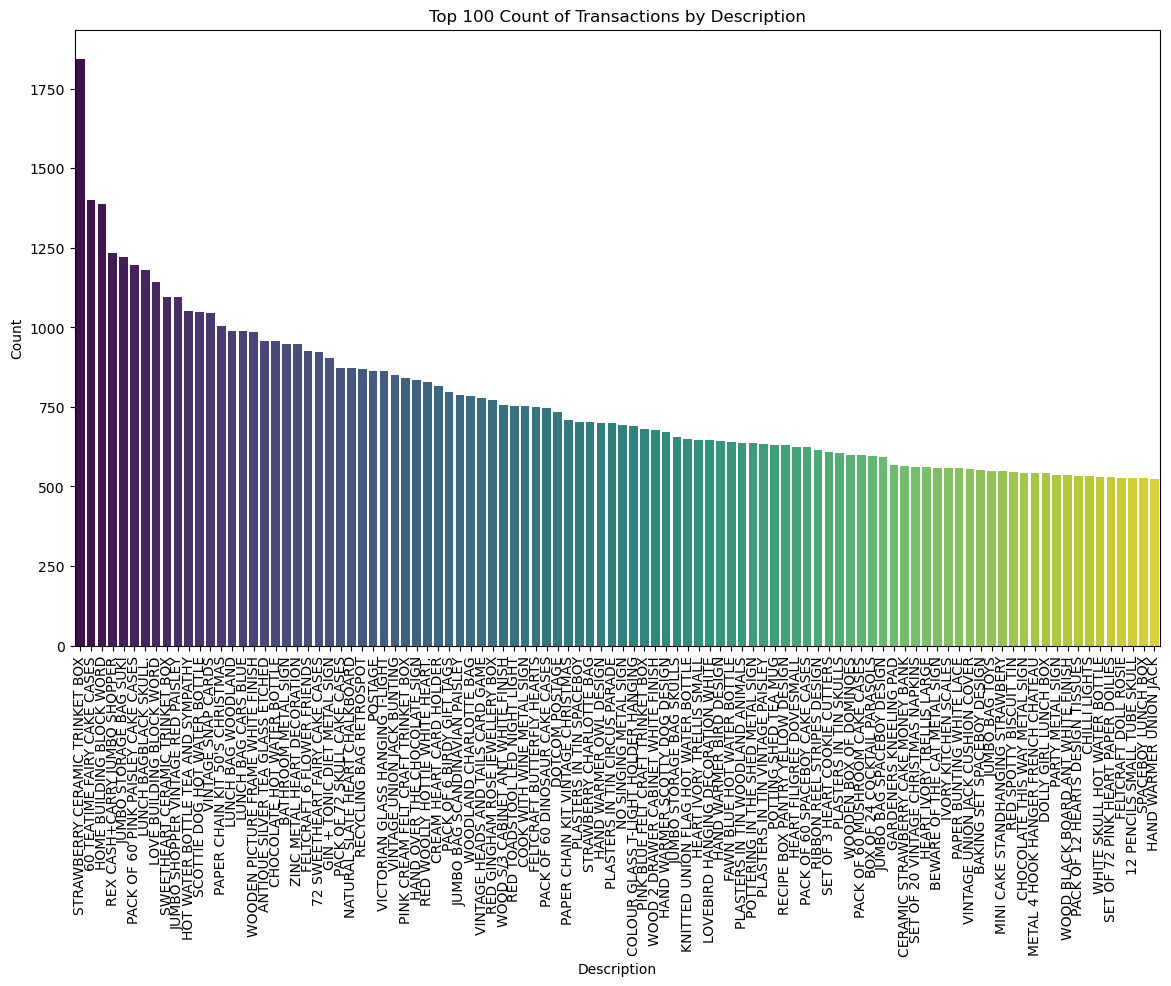

In [62]:
plt.figure(figsize=(14, 8))
sns.barplot(x=description_counts.index, y=description_counts.values, palette='viridis')
plt.title('Top 100 Count of Transactions by Description')
plt.xlabel('Description')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

In [63]:
# Top 100 Count of Transactions by Invoice

In [64]:
invoice_counts = df['Invoice'].value_counts().head(100)
invoice_counts = invoice_counts.sort_values(ascending=False)

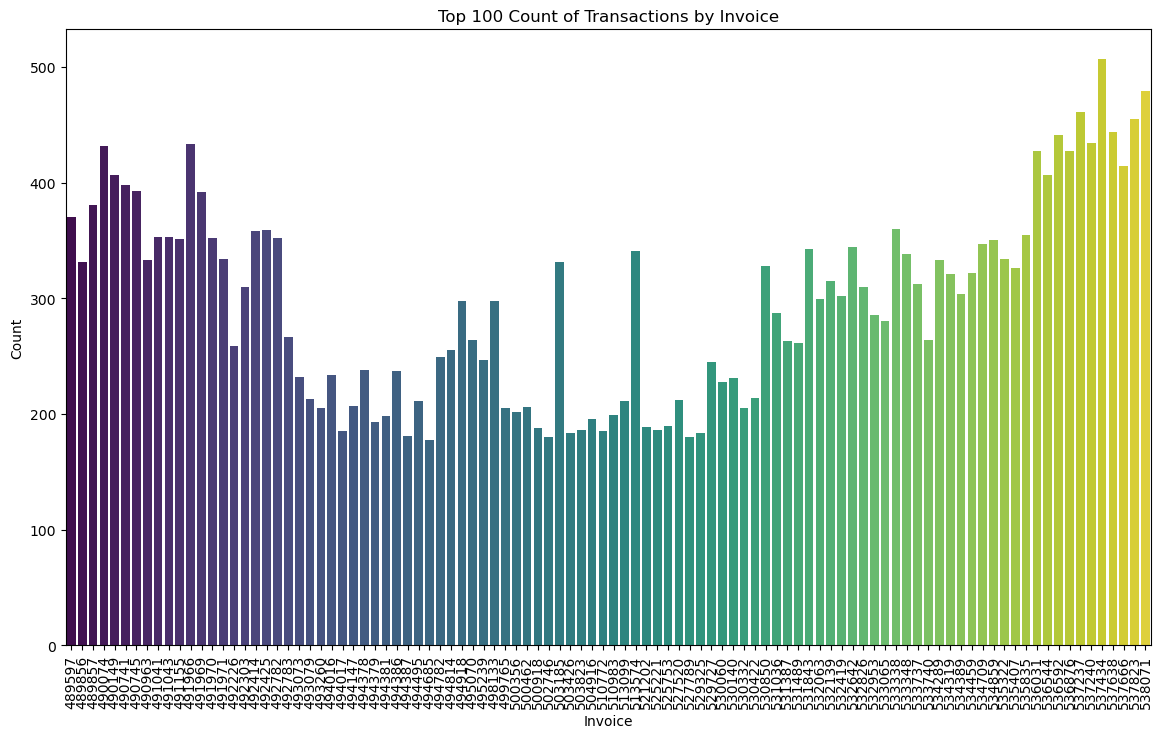

In [65]:
plt.figure(figsize=(14, 8))
sns.barplot(x=invoice_counts.index, y=invoice_counts.values, palette='viridis')
plt.title('Top 100 Count of Transactions by Invoice')
plt.xlabel('Invoice')
plt.ylabel('Count')
plt.xticks(rotation=90) 
plt.show()

In [66]:
# Count of Transactions by Day of Week and Month of Year

In [67]:
df['DayOfWeek'] = df['InvoiceDate'].dt.day_name()
df['MonthOfYear'] = df['InvoiceDate'].dt.month

In [68]:
transaction_counts = df.groupby(['MonthOfYear', 'DayOfWeek']).size().unstack(fill_value=0)

In [69]:
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
transaction_counts = transaction_counts.reindex(columns=days_order, fill_value=0)

In [70]:
month_names = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 
               7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}
transaction_counts.index = transaction_counts.index.map(month_names)

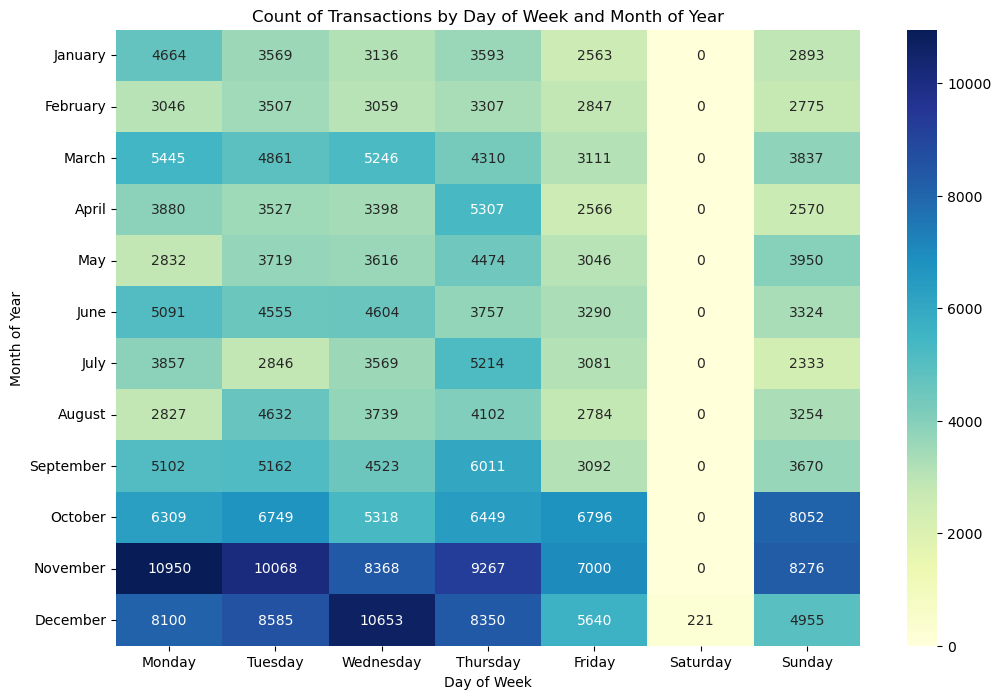

In [71]:
plt.figure(figsize=(12, 8))
sns.heatmap(transaction_counts, cmap="YlGnBu", annot=True, fmt="d")
plt.title('Count of Transactions by Day of Week and Month of Year')
plt.xlabel('Day of Week')
plt.ylabel('Month of Year')
plt.show()

# 4. Model

In [72]:
# set list

In [73]:
# txn_list = [['I1','I2','I5'],
#             ['I2','I4'],
#             ['I2','I3'],
#             ['I1','I2','I4'],
#             ['I1','I3'],
#             ['I2','I3'],
#             ['I1','I3'],
#             ['I1','I2','I3','I5'],
#             ['I1','I2','I3']]
# item_list = ['I1','I2','I3','I4','I5']
# max_no_item_invoice = 4

In [74]:
txn_list = df.groupby('Invoice')['Description'].apply(list).tolist()
item_list = df['Description'].unique().tolist()
max_no_item_invoice = df.groupby('Invoice')['Description'].nunique().reset_index()['Description'].max()

In [75]:
# first step (support)

In [76]:
encoder = TransactionEncoder()
onehot = encoder.fit(txn_list).transform(txn_list)
df_item = pd.DataFrame(onehot, columns=encoder.columns_)

In [77]:
support_result = apriori(df_item, min_support=0.005, use_colnames=True)

In [78]:
support_result

,support,itemsets
0,0.005951,(12 COLOURED PARTY BALLOONS)
1,0.005995,(12 DAISY PEGS IN WOOD BOX)
2,0.005334,(12 EGG HOUSE PAINTED WOOD)
3,0.008507,(12 IVORY ROSE PEG PLACE SETTINGS)
4,0.009433,(12 MESSAGE CARDS WITH ENVELOPES)
...,...,...
1973,0.005069,"(WHITE SPOT RED CERAMIC DRAWER KNOB, RED STRIP..."
1974,0.005113,"(WHITE SPOT RED CERAMIC DRAWER KNOB, RED STRIP..."
1975,0.005201,"(CHILDS GARDEN TROWEL BLUE, CHILDRENS GARDEN G..."
1976,0.006921,"(CHILDS GARDEN FORK PINK, CHILDS GARDEN TROWEL..."


In [79]:
# second step (confidence)

In [80]:
confidence_result = association_rules(support_result, metric="confidence", min_threshold=0.5)

In [81]:
confidence_result = confidence_result[['antecedents','consequents','confidence']]

In [82]:
confidence_result['antecedents'] = confidence_result['antecedents'].apply(lambda x: tuple(x))
confidence_result['consequents'] = confidence_result['consequents'].apply(lambda x: tuple(x))

# 5. Export

In [83]:
confidence_result.to_excel('./BE/final_result.xlsx', index=False)